## Nathan Butler | 1001805566

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
data = pd.read_csv('diabetes.csv')

## 1.) Data Preparation

In [49]:
data.head(5)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [50]:
data.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [51]:
data.isna().sum()
# As we can see, there are no missing values.

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## Descriptive stats in the form of a plot

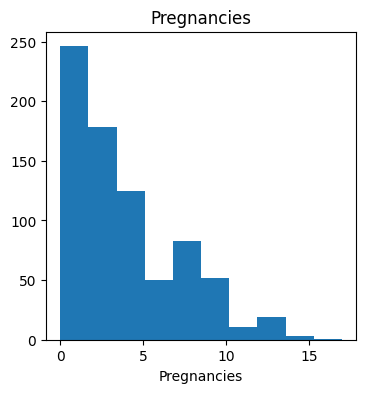

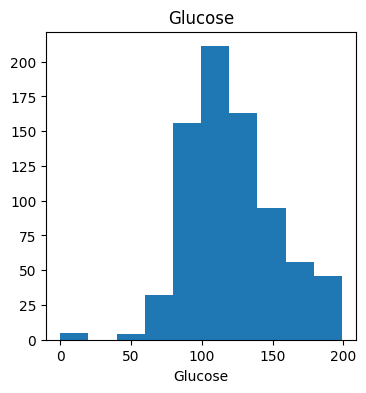

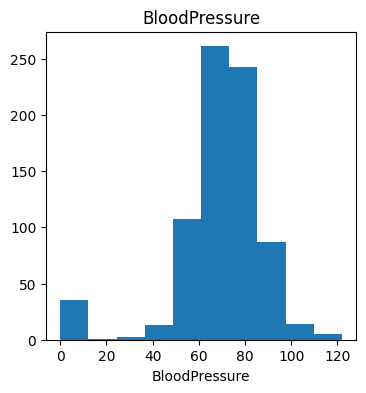

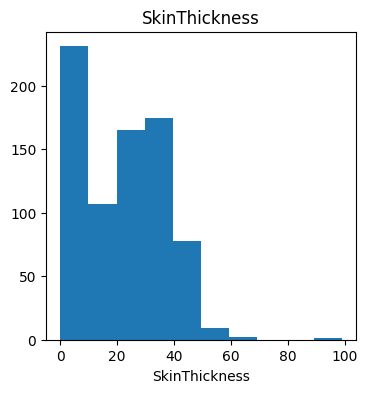

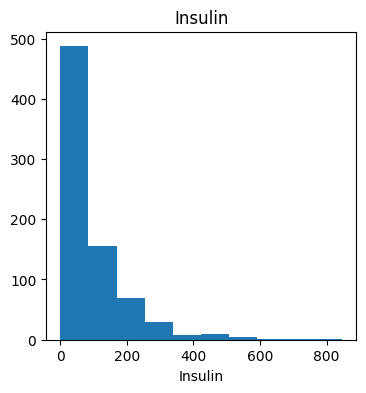

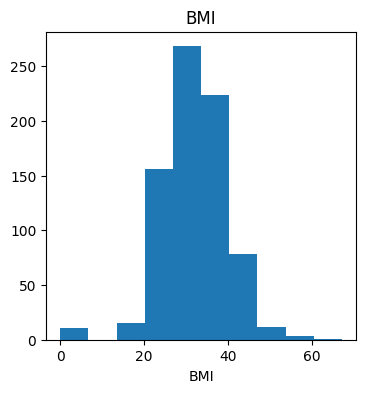

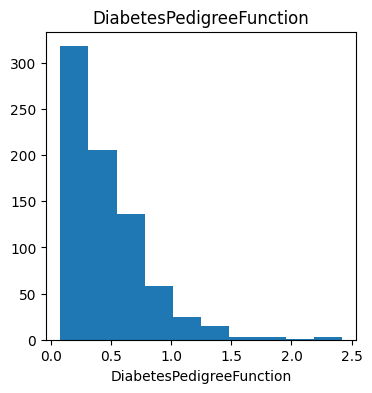

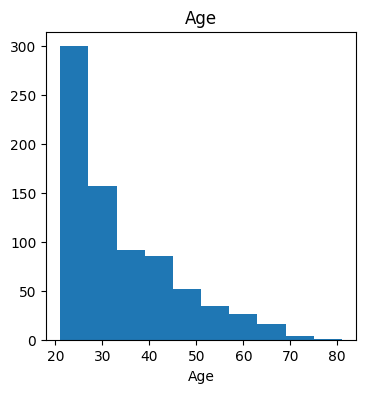

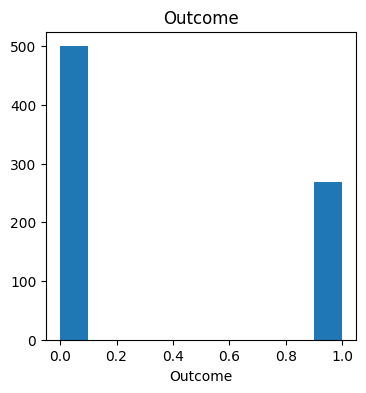

In [52]:
for col in data.columns:
    plt.figure(figsize=(4,4))
    plt.hist(data[col])
    plt.title(col)
    plt.xlabel(col)
    plt.show()

### A new feature called 'Glucose-to-Insulin'

In [53]:
data['Glucose-to-Insulin'] = data['Glucose'] / data['Insulin']

In [54]:
data

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  Glucose-to-Insulin  
0                       0.627   50        1                 inf  
1                       0.351   31        0                 inf  
2                       0.672   32        1                 inf  
3                       0.167   21        0            0.946809  
4                       2.288   33        1            0.815476  
..                        ...  ...      ...                 ...  
763                     0.171   63        0            0.561111  
764                     0.340   27        0                 inf  
765                     0.245   30        0            1.080357  
766                     0.349   47        1                 inf  
767                     0.315   23        0                 inf  

[768 rows x 10 columns]

## splitting the dataframe

In [33]:
# Shuffle the DataFrame
df_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split index
split = int(0.8 * len(df_shuffled))

# Split into train/test
train_df = df_shuffled[:split]
test_df = df_shuffled[split:]

### 2.) Decision Tree Classifier

In [59]:
import numpy as np
from collections import Counter

# --- Entropy Calculation ---
def entropy(y):
    counts = Counter(y)
    total = len(y)
    return -sum((count/total) * np.log2(count/total) for count in counts.values())

# --- Information Gain ---
def info_gain(y, x_column, threshold):
    left_mask = x_column <= threshold
    right_mask = ~left_mask

    y_left, y_right = y[left_mask], y[right_mask]
    if len(y_left) == 0 or len(y_right) == 0:
        return 0

    parent_entropy = entropy(y)
    n = len(y)
    child_entropy = (len(y_left)/n) * entropy(y_left) + (len(y_right)/n) * entropy(y_right)

    return parent_entropy - child_entropy

# --- Decision Tree Node ---
class DecisionNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value  # for leaf nodes

# --- Tree Builder ---
def build_tree(X, y, depth=0, max_depth=5):
    if len(set(y)) == 1 or depth == max_depth:
        return DecisionNode(value=Counter(y).most_common(1)[0][0])

    best_gain = 0
    best_feature = None
    best_threshold = None

    for feature in range(X.shape[1]):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            gain = info_gain(y, X[:, feature], threshold)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_threshold = threshold

    if best_gain == 0:
        return DecisionNode(value=Counter(y).most_common(1)[0][0])

    left_mask = X[:, best_feature] <= best_threshold
    right_mask = ~left_mask

    left = build_tree(X[left_mask], y[left_mask], depth+1, max_depth)
    right = build_tree(X[right_mask], y[right_mask], depth+1, max_depth)

    return DecisionNode(feature=best_feature, threshold=best_threshold, left=left, right=right)

# --- Prediction ---
def predict_tree(node, x):
    if node.value is not None:
        return node.value
    if x[node.feature] <= node.threshold:
        return predict_tree(node.left, x)
    else:
        return predict_tree(node.right, x)

def predict_all(tree, X):
    return np.array([predict_tree(tree, x) for x in X])

# --- Evaluation ---
def evaluate(y_true, y_pred):
    accuracy = np.mean(y_true == y_pred)
    print("Accuracy:", accuracy)
    print("Class distribution:", Counter(y_pred))

# --- Example Usage ---
if __name__ == "__main__":
    # Simulated dataset
    from sklearn.datasets import load_iris
    data = load_iris()
    X = data.data
    y = data.target

    # Shuffle and split
    np.random.seed(42)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    split = int(0.8 * len(X))
    train_idx, test_idx = indices[:split], indices[split:]

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Train and predict
    tree = build_tree(X_train, y_train, max_depth=5)
    y_pred = predict_all(tree, X_test)

    # Evaluate
    evaluate(y_test, y_pred)


Accuracy: 0.9333333333333333
Class distribution: Counter({1: 13, 2: 10, 0: 7})


### 3.) Random Forest Classifier.

In [60]:
class RandomForestClassifier:
    def __init__(self, n_trees=10, max_depth=5, sample_size=None, n_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.sample_size = sample_size
        self.n_features = n_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        n_samples = X.shape[0]
        self.sample_size = self.sample_size or n_samples
        self.n_features = self.n_features or X.shape[1]

        for _ in range(self.n_trees):
            # Bootstrap sample
            indices = np.random.choice(n_samples, self.sample_size, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]

            # Feature subsampling
            feature_indices = np.random.choice(X.shape[1], self.n_features, replace=False)
            X_subsample = X_sample[:, feature_indices]

            # Train tree
            tree = build_tree(X_subsample, y_sample, max_depth=self.max_depth)
            self.trees.append((tree, feature_indices))

    def predict(self, X):
        tree_preds = []
        for tree, feature_indices in self.trees:
            X_subset = X[:, feature_indices]
            preds = predict_all(tree, X_subset)
            tree_preds.append(preds)

        # Majority vote
        tree_preds = np.array(tree_preds).T
        return np.array([Counter(row).most_common(1)[0][0] for row in tree_preds])

In [61]:
rf = RandomForestClassifier(n_trees=50, max_depth=5, n_features=2)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

accuracy_rf = np.mean(y_pred_rf == y_test)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.9666666666666667


In [62]:
def feature_importance(rf_model, n_total_features):
    importance = np.zeros(n_total_features)
    for _, feature_indices in rf_model.trees:
        for idx in feature_indices:
            importance[idx] += 1
    return importance / rf_model.n_trees

importance_scores = feature_importance(rf, X.shape[1])
print("Feature importances:", importance_scores)

Feature importances: [0.64 0.44 0.58 0.34]


### 4.) K-Nearest Neighbors (KNN) Classifier

In [63]:
import numpy as np
from collections import Counter

class KNNClassifier:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        return np.array([self._predict(x) for x in X])

    def _predict(self, x):
        distances = np.linalg.norm(self.X_train - x, axis=1)
        k_indices = np.argsort(distances)[:self.k]
        k_labels = self.y_train[k_indices]
        return Counter(k_labels).most_common(1)[0][0]


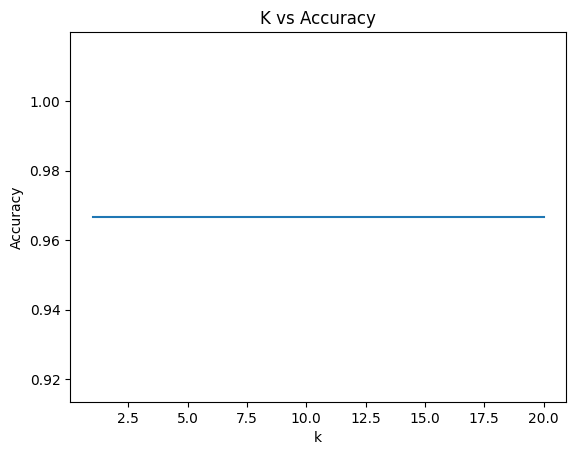

In [64]:
accuracies = []
for k in range(1, 21):
    knn = KNNClassifier(k=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = np.mean(y_pred == y_test)
    accuracies.append(acc)

# Plotting
import matplotlib.pyplot as plt
plt.plot(range(1, 21), accuracies)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('K vs Accuracy')
plt.show()


In [65]:
def precision_recall(y_true, y_pred, positive_class):
    tp = sum((y_true == positive_class) & (y_pred == positive_class))
    fp = sum((y_true != positive_class) & (y_pred == positive_class))
    fn = sum((y_true == positive_class) & (y_pred != positive_class))

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    return precision, recall


In [66]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNNClassifier(k=5)
knn.fit(X_train_scaled, y_train)
y_pred_scaled = knn.predict(X_test_scaled)

accuracy_scaled = np.mean(y_pred_scaled == y_test)
print("Accuracy after scaling:", accuracy_scaled)


Accuracy after scaling: 0.9666666666666667


### 5.) Discussion

> The random forest model is the most accurate because it works with sampling distribution, which is great for when we want to make an accurate prediction about our population.
> The single decision tree is ok for making a quick prediciton, which is why it is the least accurate at about 93%
> The nearest k is equally accurate as the random forest model because in many ways, they are the same exept that the neart k just chooses samples sequentially instead of randomly.

### If I had to choose...
> I would choose the random forest model.